<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle

## Подготовка данных

In [ ]:
data = pd.read_csv('/datasets/Churn.csv')
display(data.head())
data.info()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


К анализу предоставлены данные:

**Признаки:**

- `RowNumber` — индекс строки в данных
- `CustomerId` — уникальный идентификатор клиента
- `Surname` — фамилия
- `CreditScore` — кредитный рейтинг
- `Geography` — страна проживания
- `Gender` — пол
- `Age` — возраст
- `Tenure` — сколько лет человек является клиентом банка
- `Balance` — баланс на счёте
- `NumOfProducts` — количество продуктов банка, используемых клиентом
- `HasCrCard` — наличие кредитной карты
- `IsActiveMember` — активность клиента
- `EstimatedSalary` — предполагаемая зарплата

**Целевой признак**

`Exited` — факт ухода клиента

Есть незаполненные значения в колонке `Tenure`. Проверим какие значения кроме незаполеннных есть в этой колонке

In [ ]:
data['Tenure'].unique()

array([ 2.,  1.,  8.,  7.,  4.,  6.,  3., 10.,  5.,  9.,  0., nan])

Значение 0 есть отдельно, значит пустые значения не означают, что клиент является клиентом менее года. Вероятно произошла какая-то техническая проблема при подготовке данных для анализа. Проверим распределение по кредитному рейтингу (в нем обычно учитывается большое количество признаков в том числе и время обслуживания в банке), проверим соответствуют ли значения "среднему по больнице"

In [ ]:
corr = data[~data['Tenure'].isna()].corr()
corr.style.background_gradient(cmap='coolwarm')

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,1.000000,0.004289,0.002330,0.000681,-0.007322,-0.005921,0.009078,0.001248,0.009536,-0.004854,-0.014562
CustomerId,0.004289,1.000000,-0.001610,0.010379,-0.021418,-0.007445,0.014604,-0.019891,0.001499,0.010029,-0.007040
CreditScore,0.002330,-0.001610,1.000000,-0.004504,-0.000062,0.002804,0.011090,-0.003937,0.030947,0.005182,-0.023950
Age,0.000681,0.010379,-0.004504,1.000000,-0.013134,0.031481,-0.031877,-0.014129,0.082269,-0.007037,0.283017
Tenure,-0.007322,-0.021418,-0.000062,-0.013134,1.000000,-0.007911,0.011979,0.027232,-0.032178,0.010520,-0.016761
Balance,-0.005921,-0.007445,0.002804,0.031481,-0.007911,1.000000,-0.301858,-0.019055,-0.003285,0.014351,0.117218
NumOfProducts,0.009078,0.014604,0.011090,-0.031877,0.011979,-0.301858,1.000000,0.005805,0.009084,0.013990,-0.050271
HasCrCard,0.001248,-0.019891,-0.003937,-0.014129,0.027232,-0.019055,0.005805,1.000000,-0.008810,-0.006136,-0.005411
IsActiveMember,0.009536,0.001499,0.030947,0.082269,-0.032178,-0.003285,0.009084,-0.008810,1.000000,-0.020049,-0.155062
EstimatedSalary,-0.004854,0.010029,0.005182,-0.007037,0.010520,0.014351,0.013990,-0.006136,-0.020049,1.000000,0.016029


In [ ]:
median_for_age = data.loc[~data['Tenure'].isna()].groupby(by='Age')['Tenure'].median()

median_for_age.head()

Age
18    4.5
19    5.0
20    4.0
21    4.0
22    6.0
Name: Tenure, dtype: float64

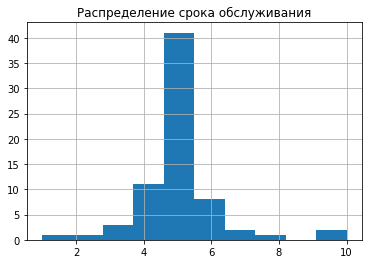

In [ ]:
median_for_age.hist(bins=10)
plt.title('Распределение срока обслуживания')
plt.show()

Явно очень много клиентов находятся на обслуживании 5 лет, возможно рассматриваемый банк образован слиянием или другим преобразованием и исчисление срока обслуживания в банке идет с этой даты.

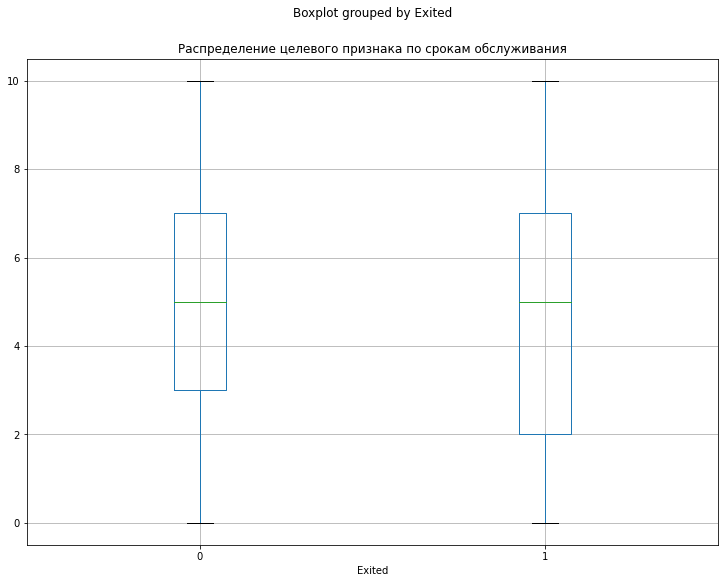

In [ ]:
data[~data['Tenure'].isna()].boxplot(column=['Tenure'], by = 'Exited', figsize = (12,9))
plt.title('Распределение целевого признака по срокам обслуживания')
plt.show()

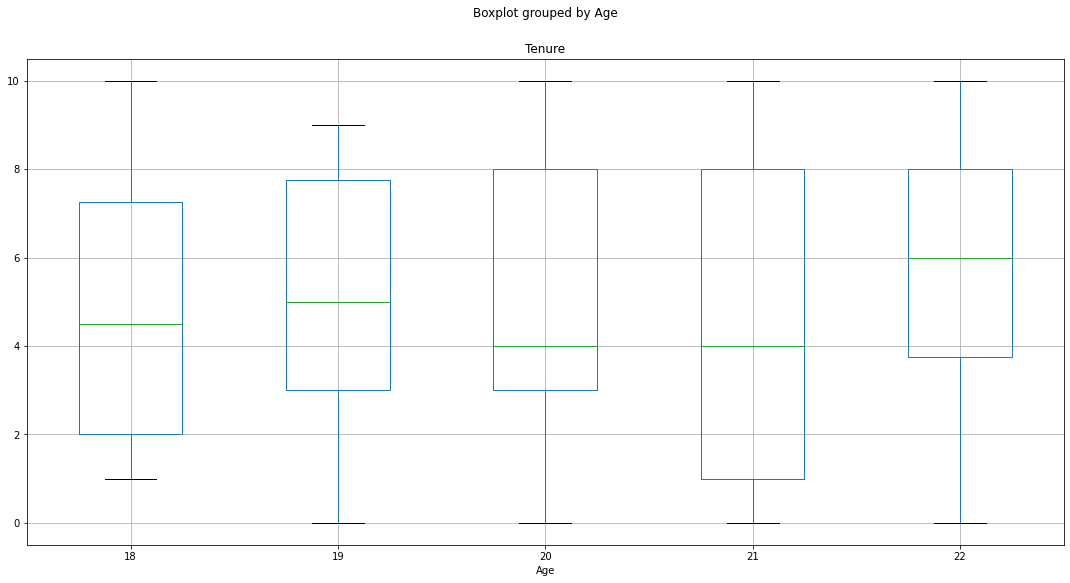

In [ ]:
data[(~data['Tenure'].isna())&(data['Age']<23)].boxplot(column=['Tenure'], by = 'Age', figsize = (18,9))

plt.show()

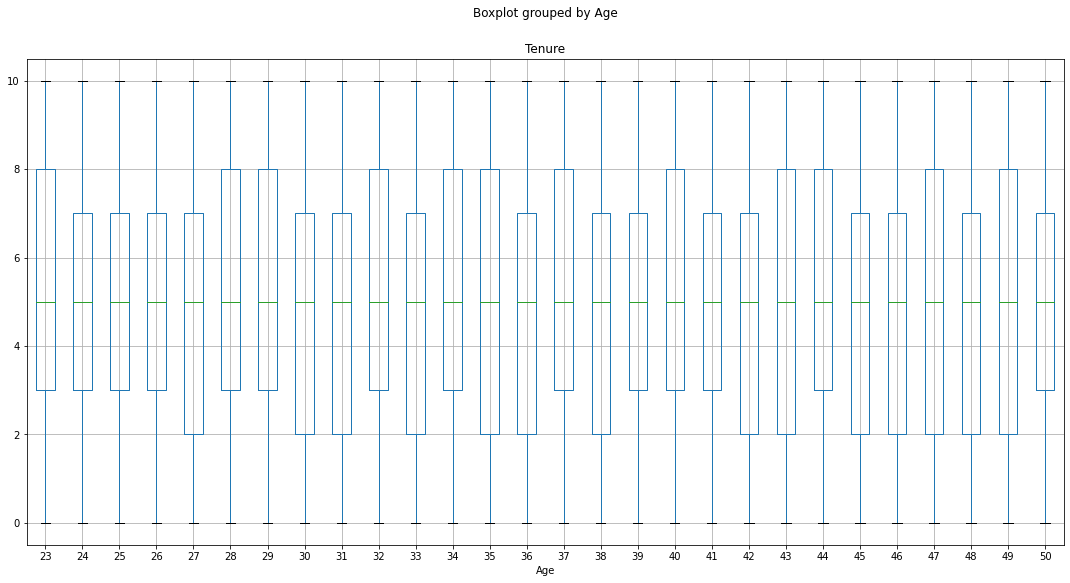

In [ ]:
data[(~data['Tenure'].isna())&(data['Age']>=23)&(data['Age']<=50)].boxplot(column=['Tenure'], by = 'Age', figsize = (18,9))

plt.show()

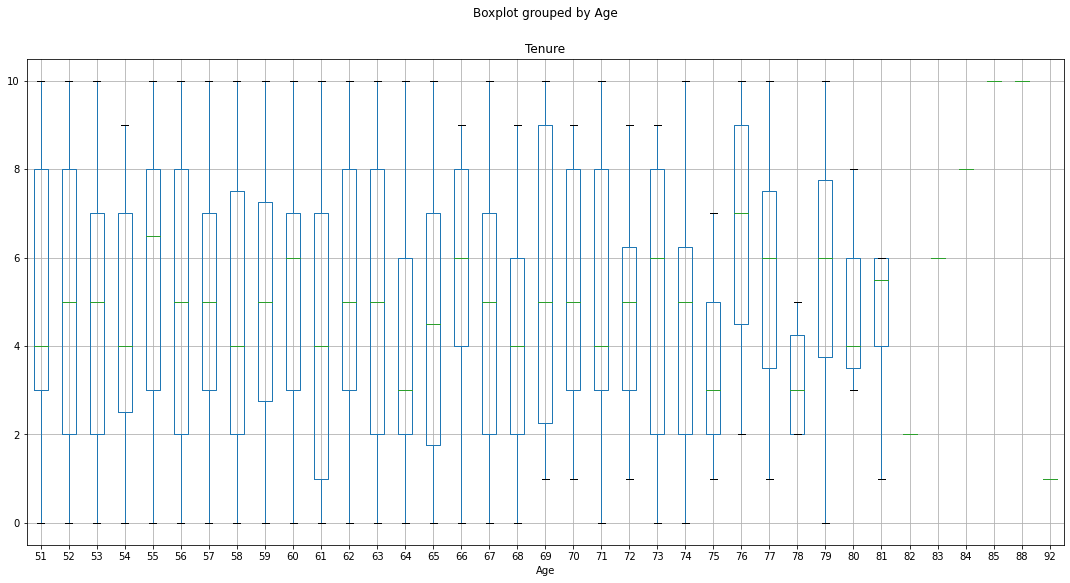

In [ ]:
data[(~data['Tenure'].isna())&(data['Age']>50)].boxplot(column=['Tenure'], by = 'Age', figsize = (18,9))

plt.show()

Очень странно, что медианное значение для большого диапазона (с 23 до 50 лет включительно) одинаково (5 лет). Однако заполнить эти данные более точно, чем для каждого возраста будет проблематично

In [ ]:
data_befor_filling = data #Сохранила для потомков
for i in median_for_age.index:
    data.loc[data['Age']==i, 'Tenure'] =  data.loc[data['Age']==i,'Tenure'].fillna(median_for_age[i])
data['Tenure'].isna().sum()

0

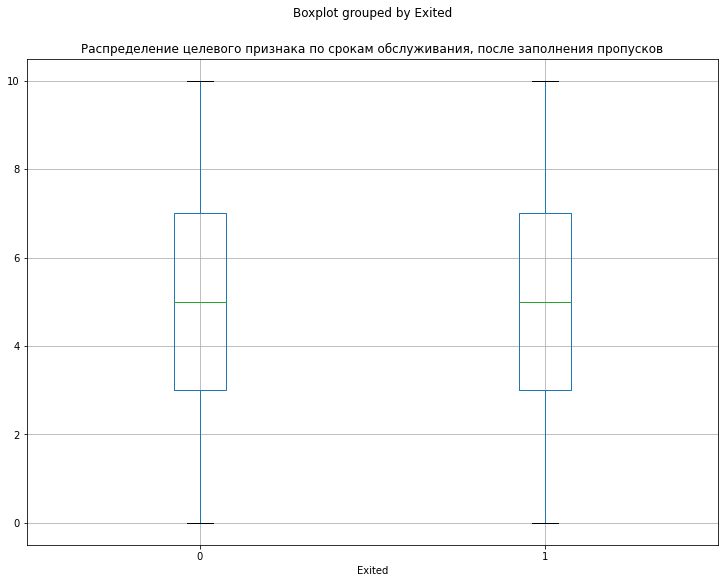

In [ ]:
data.boxplot(column=['Tenure'], by = 'Exited', figsize = (12,9))
plt.title('Распределение целевого признака по срокам обслуживания, после заполнения пропусков')
plt.show()

Предполагаем, что медианное значение 5 лет в большинстве групп скорее всего связано со стандартным сроком действия банковских карт, при этом клиент может обслуживаться уже в другом банке, но при этом иметь незакрытую карту в исследуемом банке.

Если это предположение верно, то такие данные скорее запутают нашу модель, чем добавят ей точности и полноты прогноза

Для удобства дальнейшей работы приведем к стандартному виду наименования столбцов


In [ ]:
data=data.rename(columns={"RowNumber": "row_number", "CustomerId": "customer_id", "CreditScore": "credit_score", "NumOfProducts": "num_of_products", "HasCrCard":"has_cr_card", "IsActiveMember": "is_active_member", "EstimatedSalary": "estimated_salary"})
data = data.rename(columns=str.lower)
data.head()

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


В данных предоставленных к анализу есть категориальные признаки Страна проживания и пол, их необходимо закодировать для анализа.
Признак Фамилия не имеет ценности для прогнозирования, поэтому приводить его не будем

In [ ]:
data_original = data #сохраним для потомков
data = data.drop(['row_number', 'customer_id','surname', 'tenure'], axis=1)

In [ ]:
data_befor_filling=data_befor_filling.rename(columns={"RowNumber": "row_number", "CustomerId": "customer_id", "CreditScore": "credit_score", "NumOfProducts": "num_of_products", "HasCrCard":"has_cr_card", "IsActiveMember": "is_active_member", "EstimatedSalary": "estimated_salary"})
data_befor_filling = data_befor_filling.rename(columns=str.lower)


In [ ]:
encoder = OrdinalEncoder()
#encoder.fit_transform(data)
data = pd.DataFrame(encoder.fit_transform(data), columns=data.columns)
data.head()

,credit_score,geography,gender,age,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,228.0,0.0,0.0,24.0,0.0,0.0,1.0,1.0,5068.0,1.0
1,217.0,2.0,0.0,23.0,743.0,0.0,0.0,1.0,5639.0,0.0
2,111.0,0.0,0.0,24.0,5793.0,2.0,1.0,0.0,5707.0,1.0
3,308.0,0.0,0.0,21.0,0.0,1.0,0.0,0.0,4704.0,0.0
4,459.0,2.0,0.0,25.0,3696.0,0.0,1.0,1.0,3925.0,0.0


Отделим тестовые данные для проверки готовой модели

In [ ]:
data_train, data_test = train_test_split(
    data, test_size=0.2, random_state=613, stratify = data['exited']) #балансируем по целевому признаку
features_test = data_test.drop('exited', axis=1)
target_test = data_test['exited']

Теперь аналогично разделим оставшиеся данные на обучающую и валидационную выборки

In [ ]:
features = data_train.drop('exited', axis=1)
target = data_train['exited']
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25, random_state=613, stratify = data_train['exited'])

## Исследование задачи

Попробуем обучить модели на имеющейся выборке и проверим метрики. Начнем с дерева решений.

In [ ]:
max_score = 0
best_depth = 1
for depth in range(1, 25, 1):
    model = DecisionTreeClassifier(max_depth=depth, random_state=613)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid)
    if result > max_score:
        max_score = result
        best_depth = depth
        r_a_score = roc_auc_score(target_valid, predicted_valid)

print("Глубина:", best_depth, "F1:", max_score)
print("ROC AUC:", r_a_score)

Глубина: 5 F1: 0.534621578099839
ROC AUC: 0.6888652905602057


Попробуем подобрать парамтеры для обучения случайного леса

In [ ]:
def search_param(features_train, target_train, features_valid, target_valid):
    max_score = 0
    best_depth = 1
    best_estimators = 1
    for estimators in range(1, 30, 1):
        for depth in range(1, 25, 1):
            test_model = RandomForestClassifier(n_estimators=estimators, max_depth=depth, random_state=613)
            test_model.fit(features_train, target_train)
            predicted_valid = test_model.predict(features_valid)
            result = f1_score(target_valid, predicted_valid)
            if result > max_score:
                max_score = result
                best_depth = depth
                best_estimators = estimators
                r_a_score = roc_auc_score(target_valid, predicted_valid)
    return best_estimators, best_depth, max_score, r_a_score

In [ ]:
%%time
best_estimators, best_depth, max_score, r_a_score =  search_param(features_train, target_train, features_valid, target_valid)
print("Количество деревьев:", best_estimators, "Глубина:", best_depth,  "F1:", max_score)
print("ROC AUC:", r_a_score)

Количество деревьев: 18 Глубина: 10 F1: 0.5965463108320251
ROC AUC: 0.7208603056060683
CPU times: user 1min 5s, sys: 220 ms, total: 1min 5s
Wall time: 1min 5s


In [ ]:
model = LogisticRegression(random_state=613, solver='liblinear')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('F1 без балансировки:', f1_score(target_valid, predicted_valid))
print("ROC AUC:", roc_auc_score(target_valid, predicted_valid))
model = LogisticRegression(random_state=613, solver='liblinear', class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('F1 сбалансированной:', f1_score(target_valid, predicted_valid))
print("ROC AUC:", roc_auc_score(target_valid, predicted_valid))

F1 без балансировки: 0.2581888246628131
ROC AUC: 0.5681852885242715
F1 сбалансированной: 0.4932003626473255
ROC AUC: 0.701070099375184


**Вывод:** Максимальное значение F1-меры = 0,58 без изменения дисбаланса на исследованных гиперпараметрах можно получить используя модель случайного леса с глубиной 13 и количеством деревьев 100.

## Борьба с дисбалансом

In [ ]:
def target_share(target_train):
    count_zero = target_train[target_train == 0].count()
    count_one = target_train[target_train == 1].count()
    display('Оставшиеся клиенты составляют', count_zero/(count_zero+count_one))
    display('Ушедшие клиенты составляют', count_one/(count_zero+count_one))
target_share(target_train)

'Оставшиеся клиенты составляют'

0.7961666666666667

'Ушедшие клиенты составляют'

0.20383333333333334

Попробуем увеличить количество записей об ушедших клиентах в обучающей выборке

In [ ]:
features_zeros = features_train[target_train == 0]
features_ones = features_train[target_train == 1]
target_zeros = target_train[target_train == 0]
target_ones = target_train[target_train == 1]

features_upsampled = pd.concat([features_zeros] + [features_ones] * 4)
target_upsampled = pd.concat([target_zeros] + [target_ones] * 4)

features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=613)

In [ ]:
target_share(target_upsampled)

'Оставшиеся клиенты составляют'

0.49405315958216983

'Ушедшие клиенты составляют'

0.5059468404178302

Теперь доли ушедших и оставшихся клиентов соизмеримы, попробуем переобучить  модель

In [ ]:
%%time
best_estimators, best_depth, max_score, r_a_score =  search_param(features_upsampled, target_upsampled, features_valid, target_valid)
print("Количество деревьев:", best_estimators, "Глубина:", best_depth,  "F1:", max_score)
print("ROC AUC:", r_a_score)

model = RandomForestClassifier(n_estimators=best_estimators, max_depth=best_depth, random_state=613)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
result = f1_score(target_valid, predicted_valid)
print("F1:", result)
print("ROC AUC:", roc_auc_score(target_valid, predicted_valid))

Количество деревьев: 23 Глубина: 11 F1: 0.624113475177305
ROC AUC: 0.769396515159227
F1: 0.624113475177305
ROC AUC: 0.769396515159227
CPU times: user 1min 28s, sys: 216 ms, total: 1min 28s
Wall time: 1min 28s


**Вывод:** проведена балансировка классов увеличением выборки, после балансировки F1-мера достигла 0,62, и наша модель стала отличаться от случайной на 76,9% :)

Попробуем сбалансировать баланс классов другим способом:

In [ ]:
features_downsampled = pd.concat([features_zeros.sample(frac=0.25, random_state=613)] + [features_ones])
target_downsampled = pd.concat([target_zeros.sample(frac=0.25, random_state=613)] + [target_ones])

features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=613)

In [ ]:
target_share(target_downsampled)

'Оставшиеся клиенты составляют'

0.4940008274720728

'Ушедшие клиенты составляют'

0.5059991725279271

In [ ]:
%%time
best_estimators, best_depth, max_score, r_a_score =  search_param(features_downsampled, target_downsampled, features_valid, target_valid)
print("Количество деревьев:", best_estimators, "Глубина:", best_depth,  "F1:", max_score)
print("ROC AUC:", r_a_score)

model_down = RandomForestClassifier(n_estimators=best_estimators, max_depth=best_depth, random_state=613)
model_down.fit(features_downsampled, target_downsampled)
predicted_valid = model_down.predict(features_valid)
result = f1_score(target_valid, predicted_valid)
print("F1:", result)
print("ROC AUC:", roc_auc_score(target_valid, predicted_valid))

Количество деревьев: 24 Глубина: 9 F1: 0.6258919469928643
ROC AUC: 0.7933457340237002
F1: 0.6258919469928643
ROC AUC: 0.7933457340237002
CPU times: user 36.6 s, sys: 188 ms, total: 36.7 s
Wall time: 36.9 s


**Вывод:** с уменьшением выборки значение F1 получается почти на 2 сотых выше, и + 2% отличия от случайной

## Тестирование модели

In [ ]:
predicted_test = model.predict(features_test)
print("F1:", f1_score(target_test, predicted_test))
print("ROC AUC:", roc_auc_score(target_test, predicted_test))

F1: 0.6032482598607888
ROC AUC: 0.7582050463406396


**Вывод:** на тестовых данных F1-мера составила немного меньше, чем на валидационной, однако так же на необходимом уровне.
Метрика AUC-ROC увеличивается при повышении F1-меры, чем точнее и полнее мы прогнозируем, тем меньше наша модель отличается от случайной

Проверим модель обученную на уменьшенной выборке

In [ ]:
predicted_test = model_down.predict(features_test)
print("F1:", f1_score(target_test, predicted_test))
print("ROC AUC:", roc_auc_score(target_test, predicted_test))

F1: 0.5784313725490197
ROC AUC: 0.7625961863249999


**Вывод:** на тестовых данных F1-мера модели обученной на уменьшенной выборки показала результат значительно хуже, чем на валидационной. Оставляем в качестве итоговой модель обученную на увеличенных данных